# Part I : Importing the data

In [26]:
# Here we import the librairies that we will use later

import keras
from keras.models import Sequential

from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split


np.random.seed(12345)
%matplotlib inline

In [19]:
# We import 2 .csv as dataframe

train_df = pd.read_csv('../data/fashion-mnist_train.csv')
test_df = pd.read_csv('../data/fashion-mnist_test.csv')

In [16]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# We create np.array because tensorflow use those

train_data = np.array(train_df, dtype ='float32')
test_data = np.array(test_df, dtype ='float32')

# Then we split (and rescale) our data sets

x_train = train_data[:, 1:] / 255   
y_train = train_data[:, 0]

x_test = test_data[:, 1:] / 255
y_test = test_data[:, 0]

In [22]:
# We create here a data set to train and one to validate

x_train, x_validate, y_train, y_validate = train_test_split(
    x_train, y_train, test_size=0.2, random_state=12345 
)

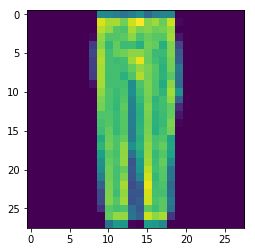

In [25]:
image = x_train[500, :].reshape(28,28)

plt.imshow(image)
plt.show()

# Part II : Create the CNN

In [28]:


im_rows =28
im_cols = 28
batch_size = 512
im_shape = (im_rows,im_cols, 1)

x_train = x_train.reshape(x_train.shape[0], *im_shape)
x_test = x_test.reshape(x_test.shape[0], *im_shape)
x_validate = x_validate.reshape(x_validate.shape[0], *im_shape)

In [29]:
print('x_train shape: {}'.format(x_train.shape))
print('x_test shape: {}'.format(x_test.shape))
print('x_validate shape: {}'.format(x_validate.shape))

x_train shape: (48000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
x_validate shape: (12000, 28, 28, 1)


In [30]:
# Define the model

cnn_model = Sequential([
    Conv2D(filters=32, kernel_size= (3,3), activation='relu', input_shape=im_shape),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    
    Flatten(),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

In [34]:
# Compile the model

cnn_model.compile(
    loss ='sparse_categorical_crossentropy',
    optimizer = Adam(lr=0.001),
    metrics = ['accuracy']
)

In [35]:
# Fit the model

cnn_model.fit(
    x_train, y_train, batch_size=batch_size,
    epochs =10, verbose= 1,
    validation_data=(x_validate,y_validate)
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 18s 379us/step - loss: 0.2898 - acc: 0.8980 - val_loss: 0.2891 - val_acc: 0.8993
Epoch 2/10
48000/48000 [==============================] - 21s 432us/step - loss: 0.2822 - acc: 0.9013 - val_loss: 0.2817 - val_acc: 0.9014
Epoch 3/10
48000/48000 [==============================] - 19s 395us/step - loss: 0.2726 - acc: 0.9026 - val_loss: 0.2793 - val_acc: 0.9008
Epoch 4/10
48000/48000 [==============================] - 19s 391us/step - loss: 0.2643 - acc: 0.9069 - val_loss: 0.2794 - val_acc: 0.9021
Epoch 5/10
48000/48000 [==============================] - 20s 420us/step - loss: 0.2572 - acc: 0.9088 - val_loss: 0.2775 - val_acc: 0.9017
Epoch 6/10
48000/48000 [==============================] - 20s 409us/step - loss: 0.2522 - acc: 0.9105 - val_loss: 0.2713 - val_acc: 0.9026
Epoch 7/10
48000/48000 [==============================] - 20s 424us/step - loss: 0.2472 - acc: 0.9120 - val_loss: 0.

In [36]:
score = cnn_model.evaluate(x_test,y_test,verbose=0)

print('test loss: {:.4f}'.format(score[0]))

print(' test acc: {:.4f}'.format(score[1]))

test loss: 0.2542
 test acc: 0.9102



# Part III : Hyperopt of keras

In [98]:
from hyperopt import Trials, STATUS_OK, tpe, rand
from keras.datasets import mnist
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils

from hyperas import optim
from hyperas.distributions import choice, uniform, conditional

In [37]:
def load_fashion_mnist():
    from keras.datasets import fashion_mnist  # this requires keras>=2.0.9
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    x = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test))
    x = x.reshape((x.shape[0], -1))
    x = np.divide(x, 255.)
    print('Fashion MNIST samples', x.shape)
    return x, y 

In [56]:
def data():
    """
    Data providing function:

    This function is separated from create_model() so that hyperopt
    won't reload data for each evaluation run.
    """
    trainTotal = np.array(pd.read_csv('../data/fashion-mnist_train.csv'))
    testTotal = np.array(pd.read_csv('../data/fashion-mnist_test.csv'))
    (x_train, y_train) = trainTotal[:, 1:], trainTotal[:, 0]
    (x_test, y_test) = testTotal[:, 1:], testTotal[:, 0]
    x_train = x_train.reshape(60000, 784)
    x_test = x_test.reshape(10000, 784)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    nb_classes = 10
    y_train = np_utils.to_categorical(y_train, nb_classes)
    y_test = np_utils.to_categorical(y_test, nb_classes)
    return x_train, y_train, x_test, y_test

In [59]:
data()

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 1., 0., 0.]]),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.00392157,
         0.        ],
        [0.        , 0.00392157, 0.01176471, ..., 0.        , 0.        ,
         0.     

In [89]:
def create_model(x_train, y_train, x_test, y_test):
    """
    Model providing function:

    Create Keras model with double curly brackets dropped-in as needed.
    Return value has to be a valid python dictionary with two customary keys:
        - loss: Specify a numeric evaluation metric to be minimized
        - status: Just use STATUS_OK and see hyperopt documentation if not feasible
    The last one is optional, though recommended, namely:
        - model: specify the model just created so that we can later use it again.
    """
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense({{choice([256, 512, 1024])}}))
    model.add(Activation({{choice(['relu', 'sigmoid'])}}))
    model.add(Dropout({{uniform(0, 1)}}))

    # If we choose 'four', add an additional fourth layer
    if conditional({{choice(['three', 'four'])}}) == 'four':
        model.add(Dense(100))

        # We can also choose between complete sets of layers

        model.add({{choice([Dropout(0.5), Activation('linear')])}})
        model.add(Activation('relu'))

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
                  optimizer={{choice(['rmsprop', 'adam', 'sgd'])}})

    model.fit(x_train, y_train,
              batch_size={{choice([64, 128])}},
              epochs=5,
              verbose=2,
              validation_data=(x_test, y_test))
    score, acc = model.evaluate(x_test, y_test, verbose=0)
    print('Test accuracy:', acc)
    return {'loss': -acc, 'status': STATUS_OK, 'model': model}

In [90]:
# if __name__ == '__main__':
best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=5,
                                      trials=Trials(),
                                      notebook_name='Keras optim')

X_train, Y_train, X_test, Y_test = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

>>> Imports:
#coding=utf-8

try:
    import keras
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
except:
    pass

try:
    from keras.optimizers import Adam
except:
    pass

try:
    from keras.callbacks import TensorBoard
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import matplotlib.image as mpimg
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from keras.datasets import mnist
except:
    pass

try:
    from keras.layers.core import Dense, Dropout, Activation
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.utils import np_utils
except:
    pass

try:
    from

In [64]:
best_model.evaluate(X_test,Y_test)

10000/10000 [==============================] - 2s 193us/step


[7.324588710784912, 0.073]

In [99]:
best_run, best_model = optim.minimize(model=create_model,
                                      data=data,
                                      algo=rand.suggest,
                                      max_evals=10,
                                      trials=Trials(),
                                      notebook_name='Keras optim')

X_train, Y_train, X_test, Y_test = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

>>> Imports:
#coding=utf-8

try:
    import keras
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
except:
    pass

try:
    from keras.optimizers import Adam
except:
    pass

try:
    from keras.callbacks import TensorBoard
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import matplotlib.image as mpimg
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from keras.datasets import mnist
except:
    pass

try:
    from keras.layers.core import Dense, Dropout, Activation
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.utils import np_utils
except:
    pass

try:
    from

In [92]:
?optim.minimize